# Natural Language Processing project

## Prespecified Model Evaluation Metrics

#### Classification Definitions:
Positive: a review that is classified by this algorithm to be toxic.

Negative: classified to not be toxic.

False Positive: classified to be toxic, while in actuality being not toxic.

False Negative: classified to be not toxic, while in actuality being toxic.

Recall (R): the number of true positives (T_p) over the number of true positives plus the number of false negatives (F_n).

Precision (P): the number of true positives (T_p) over the number of true positives plus the number of false positives (F_p).

### Discussion of False Negatives and False Positives:
It is critical to avoid false negatives. It is fine to accept false positives.
Thus we will specify a high-recall model, at the cost of some precision.

Beta (in the F-beta score): A high-recall model specifies that beta > 1, placing more weight into recall than into precision. 

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Data Description:

Toxic comment data from Wulczyn, Ellery; Thain, Nithum; Dixon, Lucas (2016): Wikipedia Detox.

figshare.doi.org/10.6084/m9.figshare.4054689

Warning: some comments in this data set contain offensive language and content. The goal is to flag for offensive behavior automatically.

### Begin with simpler cases: comments unanimously agreed upon in toxicity_score

In [5]:
os.chdir("C:/wd/Python/NLP")

comments = toxicity_annotated_comments_unanimous = pd.read_csv("data/toxicity_annotated_comments_unanimous.tsv", sep='\t')

annotations = toxicity_annotations_unanimous = pd.read_csv("data/toxicity_annotations_unanimous.tsv", sep='\t')

#### Simple data checks

In [6]:
# Verifying that values in unanimously-scored dataset truly are unanimous.
comments.shape[0] == annotations["rev_id"].nunique()

True

### Join two data files on review ID (rev_id)

- The column rev_id is a primary key in toxicity_annotated_comments_unanimous.tsv.
- Though rev_id is NOT unique in toxicity_annotations_unanimous.tsv, the column toxicity_score is unchanging (since we've confirmed a rev_id has a unanimous score).

Thus we are able to join on rev_id, to import the toxicity_score data column.
We are dropping the columns worker_id and toxicity, for they are not used in this analysis.

In [7]:
toxicity_columns = pd.DataFrame(annotations.groupby("rev_id").mean()[["toxicity_score", "toxicity"]])

df = pd.merge(comments, toxicity_columns, left_on="rev_id", right_index=True)

# Data Cleaning

### creation of new columns: string length of RAW comment

In [8]:
df["length_raw"] = list(map(len, df["comment"]))

df.head(1)

,rev_id,comment,year,logged_in,ns,sample,split,toxicity_score,toxicity,length_raw
0,527004.0,NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENNEWLINE...,2002,True,user,random,test,0.0,0.0,141


In rev_id=527004, we see the value of cleaning out "NEWLINE_TOKEN"

Every step of data cleaning is recorded in a dictionary named "log"

## remove NEWLINE_TOKEN

In [9]:
df['comment_v2'] = list(map(lambda s: s.replace("NEWLINE_TOKEN", ""), df['comment']))

log = {"v2": "'NEWLINE_TOKEN' was removed."}

df["length_v2"] = list(map(len, df["comment_v2"]))

## apply stopwords

stopwords are common words that add little predictive value. They dilute the presence of words with true predictive power. Thus they are removed.

In [10]:
stop_words = set(stopwords.words('english'))

def remove_stop_words(txt):
    words = word_tokenize(txt)
    words_filtered = []

    for w in words:
        if w not in stop_words:
            words_filtered.append(w)
    str_of_words_filtered = ' '.join(words_filtered)
    return(str_of_words_filtered)

In [11]:
df['comment_v3'] = list(map(lambda s: remove_stop_words(s), df['comment_v2']))

log["v3"] = "stop words removed."

df["length_v3"] = list(map(len, df["comment_v3"]))

## Stemming words 

By stemming words, words like 'going' and 'go' become equal and are not double-counted.

#### Stemmer Selection: Snowball

It is an improvement over the Porter stemmer.  It is more aggressive, it has a slightly faster computation time, and it is with a fairly large community around it.

https://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg

In [12]:
stemmer = stemmersnowball = SnowballStemmer("english")
from nltk.stem.porter import *
stemmerporter = PorterStemmer()

In [13]:
# demonstration of Snowball vs Porter
print(stemmersnowball.stem('significantly'))
print(stemmerporter.stem('significantly'))
print(stemmersnowball.stem('generously'))
print(stemmerporter.stem('generously'))

signific
significantli
generous
gener


In [14]:
def stemmersnowballstem(entirecomment):
    stemmedcomment_as_list = [stemmersnowball.stem(oneword) for oneword in entirecomment.split()]
    stemmedcomment = ' '.join(stemmedcomment_as_list)
    return stemmedcomment

series_comments = df['comment_v3']
df['comment_v4'] = list(map(
        lambda x: stemmersnowballstem(x), series_comments
    ))

log['v4'] = "Stemming done in NLTK.stem with Snowball(Porter2)"

df['length_v4'] = list(map(lambda s: len(s), df['comment_v4']))

#### Evaluation: How helpful is stemming words?  Let's view the before-and-after DIFFERENCE in length 

In [15]:
diff_v3_v4 = df['length_v3']-df['length_v4']

print(diff_v3_v4.sort_values(ascending=False)[0:9])

1852    705
574     536
3258    360
1071    327
1866    308
3296    302
543     295
1460    289
3306    202
dtype: int64


Result: By stemming words, i.e. removing duplicate instances that stem from the same root word, comments were reduced by hundreds of characters. This is an improvement for toxic word predictability, by further reducing the "dilution" of repeated words.

# Exploratory Histogram: 

1) Is there any relationship between true comment length and toxicity?

In [16]:
df["toxicity_score"].value_counts()

 0.0    3187
 1.0     224
-1.0     159
-2.0      12
Name: toxicity_score, dtype: int64

In [17]:
os.chdir("C:/wd/Python/NLP/img")

C:\Users\Mark\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


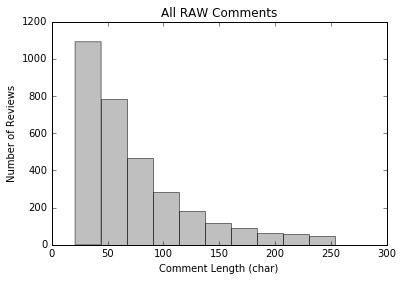

In [18]:
# Distribution of comments by length:

len_thresh0 = 255
this_col='length_raw'
df_shortcomment = df[df[this_col] < len_thresh0]

plt.hist(df_shortcomment[this_col], alpha=0.5, color='grey')
plt.xlabel('Comment Length (char)')
plt.ylabel('Number of Reviews')
plt.title('All RAW Comments')
plt.legend(loc='best')
plt.savefig('All RAW Comments, Num vs Len.png')

Most comments are under 50 characters.

Here I create subdivisions among short, long, +1 and -1 toxicity scores, for visualizations.

In [19]:
tox=1
df_toxicity_positive = df[df.toxicity_score==tox]

tox=-1
df_toxicity_negative = df[df.toxicity_score==tox]

len_thresh2 = 355
#len_thresh1 = len_thresh2
len_thresh1 = 110
df_toxicity_positive_longcomment = df_toxicity_positive[df.length_raw > len_thresh2]
df_toxicity_negative_longcomment = df_toxicity_negative[df.length_raw > len_thresh2]

df_toxicity_positive_shortcomment = df_toxicity_positive[df.length_raw < len_thresh1]
df_toxicity_negative_shortcomment = df_toxicity_negative[df.length_raw < len_thresh1]

C:\Users\Mark\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Mark\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Mark\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Mark\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### Custom plotting: histograms of unanimously-scored reviews

In [45]:
def plot_custom_hist(data_pos, data_neg, this_col, title):
    plt.hist(data_pos[this_col], alpha=0.5, label='tox=1', color='green')
    plt.hist(data_neg[this_col], alpha=0.5, label='tox=-1', color='red')
    plt.xlabel('Comment Length (char)')
    plt.ylabel('Number of Reviews')
    plt.title(title)
    plt.legend(loc='best')
    plt.savefig(title+'.png')

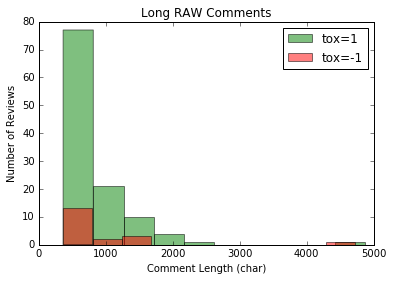

In [46]:
# long comments: raw length
plot_custom_hist(
    data_pos=df_toxicity_positive_longcomment,
    data_neg=df_toxicity_negative_longcomment,
    this_col='length_raw', title='Long RAW Comments')

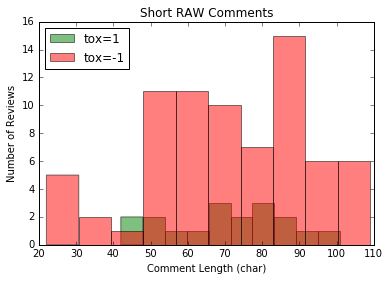

In [47]:
# short comments: raw length
plot_custom_hist(
    data_pos=df_toxicity_positive_shortcomment,
    data_neg=df_toxicity_negative_shortcomment,
    this_col='length_raw', title='Short RAW Comments')

#### Interpretation of histogram above.

This histogram shows that no short-length outliers exist. This also shows, potentially, that comments that are (UNANIMOUSLY decided upon as) toxic, tend to have a shorter comment_length. 

Two ways to think of this: 
glib and flippant comments tend to be shorter.
Simply put, if they're longer, they tend to be kinder.
One may be tempted to think from these histograms, that straight-forward predictive power lies in comment_length.
However, let's see if the word frequency explains all or most of any predictive power that's found in comment_length.

### other generated histograms 

Histograms were created for length_v2 of comments, length_v3 and length_v4.  Here's the histogram of v4 for short comments:

In [48]:
# reminder:
log

{'v2': "'NEWLINE_TOKEN' was removed.",
 'v3': 'stop words removed.',
 'v4': 'Stemming done in NLTK.stem with Snowball(Porter2)'}

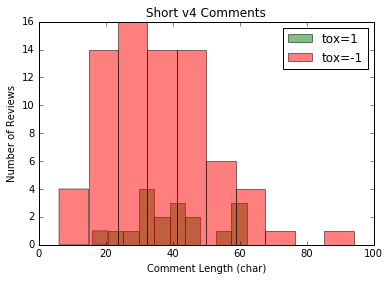

In [49]:
plot_custom_hist(
    data_pos=df_toxicity_positive_shortcomment,
    data_neg=df_toxicity_negative_shortcomment,
    this_col='length_v4', title='Short v4 Comments')

#### Observation:

Having taken these data processing steps, the short comments have gotten even shorter.  Thus short comment length (of length_v4) has more predictive power over toxicity.

# Dataset partitioning for model (on unanimous data)

In [50]:
Ycolumn = 'toxicity'

Xcolumn = 'comment_v4'

X_train, X_crossval, y_train, y_crossval = train_test_split(df[Xcolumn], df[Ycolumn], random_state=1)

count_vector = CountVectorizer()
# fit training data into `CountVectorizer()` and return the matrix.
training_data = count_vector.fit_transform(X_train)

testing_data = count_vector.transform(X_crossval)

In [53]:
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

predictions = naive_bayes.predict(testing_data)

In [54]:
print('Accuracy score: ', format(accuracy_score(y_crossval, predictions)))
precision = precision_score(y_crossval, predictions)
print('Precision score: ', format(precision))
recall = recall_score(y_crossval, predictions)
print('Recall score: ', format(recall))

print('F1 score (beta=1): ', format(f1_score(y_crossval, predictions)))
beta=2
f_beta_score = (1+beta**2)*(precision*recall)/((beta**2)*precision + recall)
print('F', beta, ' score for high-recall models (beta=', beta, '): ', f_beta_score, sep='')

Accuracy score:  0.9631696428571429
Precision score:  0.7142857142857143
Recall score:  0.35714285714285715
F1 score (beta=1):  0.4761904761904762
F2 score for high-recall models (beta=2): 0.3968253968253968


## F2 score of 39.7%

# Import, join and test on full data sets

### beginning on raw comment

This is for model comparison, to test model improvement after these data pre-processing steps.

In [56]:
Ycolumn = 'toxicity'

In [57]:
Xcolumn = 'comment'

In [58]:
## The big data
os.chdir("C:/wd/Python/NLP/data")

full_toxicity_annotated_comments = pd.read_csv("fulldata/toxicity_annotated_comments.tsv", sep='\t')

full_toxicity_annotations = pd.read_csv("fulldata/toxicity_annotations.tsv", sep='\t')
full_toxicity_score_column = pd.DataFrame(full_toxicity_annotations.groupby("rev_id").mean()["toxicity_score"])
# IMPORTANT NOTE: max function is used. This means if a review receives a single toxicity==1 entry, the aggregate will be as such.
full_toxicity_column = pd.DataFrame(full_toxicity_annotations.groupby("rev_id").max()["toxicity"])

df_right = pd.merge(full_toxicity_score_column, full_toxicity_column, left_index=True, right_index=True)

In [59]:
df = pd.merge(full_toxicity_annotated_comments, df_right, left_on="rev_id", right_index=True)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(df[Xcolumn], df[Ycolumn], random_state=1)

In [61]:
count_vector = CountVectorizer()
# fit training data into `CountVectorizer()` and return the matrix.
training_data = count_vector.fit_transform(X_train)

testing_data = count_vector.transform(X_test)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

predictions = naive_bayes.predict(testing_data)

print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
precision = precision_score(y_test, predictions)
print('Precision score: ', format(precision))
recall = recall_score(y_test, predictions)
print('Recall score: ', format(recall))

print('F1 score (beta=1): ', format(f1_score(y_test, predictions)))
beta=2
f_beta_score = (1+beta**2)*(precision*recall)/((beta**2)*precision + recall)
print('F', beta, ' score for high-recall models (beta=', beta, '): ', f_beta_score, sep='')

Accuracy score:  0.7489855217674465
Precision score:  0.7135755913609874
Recall score:  0.7137795050580099
F1 score (beta=1):  0.7136775336438185
F2 score for high-recall models (beta=2): 0.713738712995771


### Preliminary Result:

The Naive Bayes Classification model, when trained on the unanimous dataset, yielded an F2 Score (i.e., beta=2) of 39.7%. That data was pre-processed, trained and cross-validated on the column 'Comment_v4'

#### Comparison of Recall (by way of F2 score)

On the larger dataset, no data pre-processing was done, and this model yielded an F2 Score (i.e., beta=2) of 71.4%.

This is attributed to the predictive power of much more data.

#### Comparison of Accuracy

On the unanimous dataset, the trained model accuracy was 96.3%  Accuracy went down to 74.9%, as expected, because individual comments now have a range of toxicity scores.

(Precision remained around 71% in all cases, but this was never a desired evaluation metric anyway.)

## repeat data pre-processing on raw comment

This is for model comparison, to test model improvement after these data pre-processing steps.

Hypothesis: By fine-tuning the model on the larger dataset, by pre-processing a column 'Comment_v4' (of stemming, removing stopwords and NEWLINE_TOKEN), an F2 Score that is higher than 71.4% will suggest that there is predictive value in these pre-processing steps.

Hypothesis:

By fine-tuning the model on the larger dataset, by pre-processing a column 'Comment_v4' (of stemming, removing stopwords and NEWLINE_TOKEN), there is reason to believe that the F2 Score can be even higher than 71.4%

In [65]:

df['comment_v2'] = list(map(lambda s: s.replace("NEWLINE_TOKEN", ""), df['comment']))

df["length_v2"] = list(map(len, df["comment_v2"]))


df['comment_v3'] = list(map(lambda s: remove_stop_words(s), df['comment_v2']))

df["length_v3"] = list(map(len, df["comment_v3"]))


series_comments = df['comment_v3']
df['comment_v4'] = list(map(
        lambda x: stemmersnowballstem(x), series_comments
    ))

df['length_v4'] = list(map(lambda s: len(s), df['comment_v4']))


df.head()

KeyboardInterrupt: 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[Xcolumn], df[Ycolumn], random_state=1)


count_vector = CountVectorizer()

training_data = count_vector.fit_transform(X_train)

testing_data = count_vector.transform(X_test)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

predictions = naive_bayes.predict(testing_data)

#print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
#precision = precision_score(y_test, predictions)
#print('Precision score: ', format(precision))
#recall = recall_score(y_test, predictions)
print('Recall score: ', format(recall))

print('F1 score (beta=1): ', format(f1_score(y_test, predictions)))
beta=2
f_beta_score = (1+beta**2)*(precision*recall)/((beta**2)*precision + recall)
print('F', beta, ' score for high-recall models (beta=', beta, '): ', f_beta_score, sep='')